# Experiment -- Random feature

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from sklearn.kernel_approximation import Nystroem #Nystroem
import torch

df=pd.read_csv('YearPredictionMSD.txt',header=None,sep = ',')
df=df.iloc[:1000]
train,test = train_test_split(df, train_size=0.7,random_state=1)
train_y = train[0]
test_y = test[0] #response:year
train_x = train
test_x = test
del train_x[0]
del test_x[0]
train_x ##display the data

,1,2,3,4,5,6,7,8,9,10,...,81,82,83,84,85,86,87,88,89,90
731,39.93176,43.28746,-13.38596,11.97077,39.47386,-15.98213,0.40450,-0.12974,4.93046,8.47701,...,9.28421,-125.31252,0.10776,112.07104,0.58354,128.69854,-37.50035,4.97255,-73.38973,-5.31664
716,46.74950,53.94547,25.02572,5.29242,-36.49030,-2.30921,-0.88374,7.94827,2.77896,5.21121,...,-6.69378,-114.22822,170.00155,5.53618,-12.34778,18.59814,-34.67413,6.49130,-49.10779,-2.61190
640,26.02330,-201.77563,-128.76849,26.31990,63.19943,-33.42568,-20.38217,-15.65645,35.54939,21.00675,...,20.10206,-13.31202,-22.88050,99.55618,6.30266,-105.03800,57.34783,9.21763,-205.96332,21.07824
804,47.80721,25.07585,33.84950,8.05847,-22.52360,3.74708,-21.39957,-14.34260,24.15216,2.84670,...,3.71892,-203.19986,-12.75812,14.11742,-8.29798,-73.19181,-158.66941,-3.79311,-180.22609,-12.45983
737,40.19555,22.55823,-22.31865,-16.40915,20.24315,-25.18230,-1.08735,-2.01056,9.99175,9.27890,...,8.87001,-58.76444,-60.51858,81.75608,-1.32502,36.14569,33.95389,6.52971,25.39161,8.16208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
767,45.93913,19.88129,51.47329,44.70062,7.87333,38.07456,10.32526,-15.60014,15.21450,-8.71651,...,16.54059,-128.53880,251.82840,22.90044,11.47945,145.29346,46.63635,33.09373,-248.67078,0.35662
72,48.61503,60.89685,-4.13356,7.76381,-6.11871,-14.68743,11.85668,8.17211,6.15722,7.37379,...,-14.75838,6.07177,41.87603,-70.27975,-13.59340,13.63338,73.66982,11.31753,55.91604,-0.60016
908,52.08806,41.42045,24.18691,-7.90194,-7.97742,-27.57139,11.58830,0.34746,1.19699,-0.69531,...,2.51542,23.88389,18.32899,-24.27133,7.22198,-15.91165,-29.66592,2.09806,38.53232,0.92214
235,31.84167,-89.55516,47.90171,1.36908,-19.85127,38.35041,-36.09192,12.50563,4.25735,9.29543,...,37.36157,-586.29171,120.67061,234.89404,-56.33737,-195.16410,262.17781,-18.54742,57.71193,23.59455


## SVR

In [44]:
svr = GridSearchCV(
    SVR(gamma=0.1),
    param_grid={"C": np.logspace(0, 2, 10), "gamma": np.logspace(-2, 0, 10)},
)

t0 = time.time()
svr.fit(train_x, train_y)
svr_fit = time.time() - t0
y_svr=svr.predict(test_x)
svrmse=mean_squared_error(test_y,y_svr)
print(f"Best SVR with params: {svr.best_params_}")
print(f"testMSE: {svrmse:.3f}")
y_svr=svr.predict(train_x)
svrmse=mean_squared_error(train_y,y_svr)
print(f"trainMSE: {svrmse:.3f}")
print("SVR complexity and bandwidth selected and model fitted in %.3f s" % svr_fit)

Best SVR with params: {'C': 100.0, 'gamma': 0.01}
testMSE: 178.359
trainMSE: 0.010
SVR complexity and bandwidth selected and model fitted in 24.797 s


## DNN

In [17]:
nntrain_x = torch.from_numpy(train_x.to_numpy()).float()
nntrain_y = torch.squeeze(torch.from_numpy(train_y.to_numpy()).float()) 
nntest_x= torch.from_numpy(test_x.to_numpy()).float()
nntest_y = torch.squeeze(torch.from_numpy(test_y.to_numpy()).float())

In [27]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class Net(nn.Module): 
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(90, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(5, 1)
 
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = Net()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.01,momentum=0.8) #optim.Adam(...)

dnn_trainloss=[]
dnn_testloss=[]
for epoch in range(200): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 10 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
            
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        dnn_trainloss.append(float(train_loss))
        dnn_testloss.append(float(test_loss))
            
dnn_fit = time.time() - t0
print("DNN complexity and model fitted in %.3f s" % dnn_fit)

Net(
  (fc1): Linear(in_features=90, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 342625.46875
            Test  set - loss: 243909.921875
            
epoch 10
            Train set - loss: 188.890625
            Test  set - loss: 104.49170684814453
            
epoch 20
            Train set - loss: 116.5293197631836
            Test  set - loss: 106.81121826171875
            
epoch 30
            Train set - loss: 148.6772918701172
            Test  set - loss: 106.59915161132812
            
epoch 40
            Train set - loss: 280.8228454589844
            Test  set - loss: 105.52947235107422
            
epoch 50
            Train set - loss: 205.85797119140625
            Test  set - loss: 106.37751007080078
            
epoch 60
            Train set - loss: 211.4290008544922
  

## One kernel machine for different number of Random Feature

random feature class

In [2]:
def ft_gaussian(x):
    """FT of gaussian, normalized so that max_x pdf(x) = 1"""
    return np.exp(-0.5 * (np.linalg.norm(x) ** 2))

def ft_laplacian(x):
    """FT of laplacian, normalized so that max_x pdf(x) = 1"""
    return np.prod(np.asarray([1/(1 + x_i ** 2) for x_i in x]))

def ft_cauchy(x):
    """FT of cauchy, normalized so that max_x pdf(x) = 1"""
    return np.exp(-1 * sum(np.abs(x)))

KERNELS = {
    'G': ft_gaussian,
    'L': ft_laplacian,
    'C': ft_cauchy
}

def sample_1d(pdf, gamma, interval):
    """Monte-Carlo rejection sampling"""
    while True:
        w = np.random.rand(1) * (interval[1] - interval[0]) + interval[0] #U(interval)
        y = np.random.rand(1) #U[0,1]

        if y <= pdf(w/gamma):  #p_new(x) ~ p(x/gamma) -- transform the standard pdf
            return w

def sample(pdf, gamma, d):
    """Monte Carlo Rejection Sampling"""
    return [sample_1d(pdf, gamma, [-10*gamma, 10*gamma]) for _ in range(d)]


class RandomFourierFeature:
    """Random Fourier Feature
    Parameters
    ----------
    d : int
        Input space dimension
    D : int
        Feature space dimension
    W : np.array
        shape (D,d)
    b : np.array
        shape (D)
    kernel : char
        Kernel to use; 'G', 'L', or 'C'
    gamma : float
        pdf parameter
    References
    ----------
    ..  [1] A. Rahimi, B. Recht, "Random Features for Large-Scale Kernel
        Machines"
    """

    def __init__(self, d, D, W=None, b=None, kernel='G', gamma=1):

        self.d = d
        self.D = D
        self.gamma = gamma

        kernel = kernel.upper()
        if kernel not in ['G', 'L', 'C']:
            raise Exception('Invalid Kernel')
        self.kernel = kernel

        if W is None or b is None:
            self.create()
        else:
            self.__load(W, b)

    def __load(self, W, b):
        """Load from existing Arrays"""

        self.W = W.reshape([self.D, self.d])
        self.b = b
    

    def create(self):
        """Create a d->D fourier random feature"""

        self.b = np.random.uniform(0, 2 * np.pi, self.D)
        
        self.W = np.reshape(
            np.array([
                sample(KERNELS[self.kernel], self.gamma, self.d)
                for _ in range(self.D)], dtype=np.float32),
            (self.D, self.d))

    def transform(self, x):
        """Transform a vector using this feature
        Parameters
        ----------
        x : np.array (shape=(n,d))
            Array to transform; must be single dimension vector
        Returns
        -------
        x : np.array (shape=(n,D))
            Feature space transformation of x
        """
        
        result=np.array([
            np.sqrt(2 / self.D) * np.cos(np.dot(self.W, x.iloc[i]) + self.b) for i in range(len(x))]
            )
            
        return result

    def __str__(self):
        """Get string representation
        Shown as "<d>-><D> Random Fourier Feature"
        """
        return (
            "{d}->{D} Random Fourier Feature"
            .format(d=self.d, D=self.D))

gaussian kernel

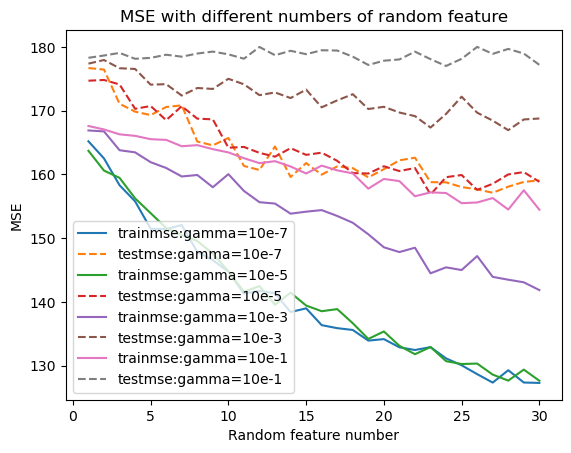

In [168]:
model =LinearRegression()
Layer=1
m0set=np.linspace(1,30,30)
m0set=m0set.astype(int)
gaset=np.logspace(-7,-1,4)
n0=16

for ga in gaset:
    trainmse=[]
    testmse=[]
    t=[]
    for m0 in m0set:  
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=ga)
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            model.fit(train_xtransformed, train_y)
            if i==0:
                y_pretest=model.predict(test_xtransformed)
                y_pretrain=model.predict(train_xtransformed)
            else:
                y_pretest=y_pretest+model.predict(test_xtransformed)
                y_pretrain=y_pretrain+model.predict(train_xtransformed) 
        
        y_pretest=y_pretest/n0
        y_pretrain=y_pretrain/n0
        
        trainmse.append(mean_squared_error(train_y,y_pretrain))
        testmse.append(mean_squared_error(test_y,y_pretest))

    plt.plot(m0set,trainmse)
    plt.plot(m0set,testmse,linestyle='dashed')
    

plt.xlabel("Random feature number")
plt.ylabel("MSE")
plt.title("MSE with different numbers of random feature")
plt.legend(["trainmse:gamma=10e-7","testmse:gamma=10e-7","trainmse:gamma=10e-5","testmse:gamma=10e-5","trainmse:gamma=10e-3","testmse:gamma=10e-3","trainmse:gamma=10e-1","testmse:gamma=10e-1"])
plt.show()


p.s. laplacian kernel and cauchy kernel results are similar to this graph.

## Network learning

In [20]:
import torch
from torch.utils.data import Dataset,DataLoader
from torch import optim
import torch.nn as nn
import torch.nn.functional as F

class mydataset(Dataset):
    def __init__(self, x, y):
        self._x = x
        self._y = y
        self._len = len(x)

    def __getitem__(self, item): 
        return self._x[item], self._y[item]

    def __len__(self):
        return self._len
    
train_loader = DataLoader(mydataset(nntrain_x, nntrain_y),batch_size=50, shuffle=True)
test_loader = DataLoader(mydataset(nntest_x, nntest_y),batch_size=50, shuffle=False)

class KernelNet(nn.Module): 
    def __init__(self):
        super(KernelNet, self).__init__()
        self.fc1 = nn.Linear(100, 60)
        self.fc2 = nn.Linear(50, 30)
        self.fc3 = nn.Linear(20, 5)
        self.fc4 = nn.Linear(3, 1)
 
    def forward(self, x):
        rff=RandomFourierFeature(90,100,kernel='G',gamma=10**(-1))
        y=x.detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(60,50,kernel='G',gamma=10**(-1))
        y=self.fc1(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(30,20,kernel='G',gamma=10**(-1))
        y=self.fc2(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        rff=RandomFourierFeature(5,3,kernel='G',gamma=10**(-1))
        y=self.fc3(x).detach().numpy()
        y=pd.DataFrame(y)
        yn = rff.transform(y)
        x = torch.from_numpy(yn).float()
        return self.fc4(x)

t0 = time.time()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = KernelNet()
net = net.to(device)
print(net)
criterion=nn.MSELoss() 
optimizer=optim.SGD(net.parameters(),lr=0.001,momentum=0.8) #optim.Adam(...)

loss=[]
kernelnn_trainloss=[]
kernelnn_testloss=[]

for epoch in range(10): 
    for x, y in train_loader: #for batch, (x, y) in enumerate(train_loader): 
        x, y = x.to(device), y.to(device)
        # Compute prediction error
        y_pred = net(x)
        y_pred = torch.squeeze(y_pred)
        train_loss = criterion(y_pred, y)
        loss.append(train_loss)
        # Backpropagation
        optimizer.zero_grad() 
        train_loss.backward()
        optimizer.step()
    if epoch % 1 == 0: 
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            y_test_pred = net(x)
            y_test_pred = torch.squeeze(y_test_pred)
    
            test_loss = criterion(y_test_pred,y)
        print(f'''epoch {epoch}
            Train set - loss: {train_loss}
            Test  set - loss: {test_loss}
            ''')
        kernelnn_trainloss.append(float(train_loss))
        kernelnn_testloss.append(float(test_loss))
        
    
dnn_fit = time.time() - t0
print("KernelNet complexity and model fitted in %.3f s" % dnn_fit)

KernelNet(
  (fc1): Linear(in_features=100, out_features=60, bias=True)
  (fc2): Linear(in_features=50, out_features=30, bias=True)
  (fc3): Linear(in_features=20, out_features=5, bias=True)
  (fc4): Linear(in_features=3, out_features=1, bias=True)
)
epoch 0
            Train set - loss: 3256193.0
            Test  set - loss: 3351642.25
            
epoch 1
            Train set - loss: 2460296.25
            Test  set - loss: 2496150.75
            
epoch 2
            Train set - loss: 1818955.25
            Test  set - loss: 1812047.375
            
epoch 3
            Train set - loss: 1375818.5
            Test  set - loss: 1275611.125
            
epoch 4
            Train set - loss: 1054446.75
            Test  set - loss: 1001790.875
            
epoch 5
            Train set - loss: 759133.375
            Test  set - loss: 738821.625
            
epoch 6
            Train set - loss: 556824.25
            Test  set - loss: 574671.5625
            
epoch 7
            Train s

## Residual learning

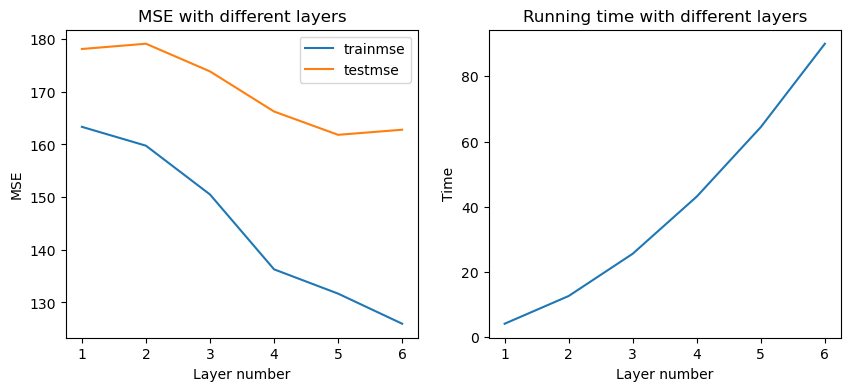

In [327]:
model = LinearRegression()
layerset=np.linspace(1,6,6)
layerset=layerset.astype(int)
m0=10
gamma0=0.1
n0=32
trainmse=[]
testmse=[]
t=[]
t0 = time.time()

for layer in layerset:
    length=int(len(train_x)/layer)
    for l in range(layer):  #ml points, nl sampling
        if l==0:
            for i in range(n0):
                rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[l*length:(l+1)*length]
                
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length])
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
            y_kr=yl_kr/n0
            y_krtrain=yl_kltrain/n0
            
        else:
            for i in range(n0):
                rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
                total_x=pd.concat([train_x,test_x])
                feature=rff.transform(total_x)
                train_xtransformed=feature[:700]
                test_xtransformed=feature[700:]
                train_xltransformed=feature[l*length:(l+1)*length]
                
                model.fit(train_xltransformed, train_y[l*length:(l+1)*length]-y_krtrain[l*length:(l+1)*length]) ##fit residual
                if i==0:
                    yl_kr=model.predict(test_xtransformed)
                    yl_kltrain=model.predict(train_xtransformed)
                else:
                    yl_kr=yl_kr+model.predict(test_xtransformed)
                    yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
            y_kr=y_kr+yl_kr/n0
            y_krtrain=y_krtrain+yl_kltrain/n0    
    
    
    kernel_fit = time.time() - t0
    
    t.append(kernel_fit)
    trainmse.append(mean_squared_error(train_y,y_krtrain))
    testmse.append(mean_squared_error(test_y,y_kr))

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(layerset,trainmse)
ax[0].plot(layerset,testmse)
ax[0].legend(["trainmse","testmse"])
ax[0].set_xlabel("Layer number")
ax[0].set_ylabel("MSE")
ax[0].set_title("MSE with different layers")

ax[1].plot(layerset,t)
ax[1].set_xlabel("Layer number")
ax[1].set_ylabel("Time")
ax[1].set_title("Running time with different layers")
plt.show()

random data splitting

In [54]:
model = LinearRegression()
m0=10
gamma0=0.00001
n0=32
t0 = time.time()
layer=4
length=int(len(train_x)/layer)


for l in range(layer):  #ml points, nl sampling
    if l==0:
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='G',gamma=gamma0/10**l)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700] 
            test_xtransformed=feature[700:]
            
            #data splitting
            a=pd.DataFrame(train_y).values
            b=pd.DataFrame(train_xtransformed).values
            a=pd.DataFrame(a)
            a.columns=['y']
            b=pd.DataFrame(b)
            concatt=pd.concat([a,b],axis=1)
            train_xltransformed,rest = train_test_split(concatt, train_size=0.4)
            train_yltransformed=train_xltransformed['y']
            del train_xltransformed['y']
                
            model.fit(train_xltransformed, train_yltransformed)
            if i==0:
                yl_kr=model.predict(test_xtransformed)
                yl_kltrain=model.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+model.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
            
        y_kr=yl_kr/n0
        y_krtrain=yl_kltrain/n0
            
    else:
        for i in range(n0):
            rff=RandomFourierFeature(90,m0,kernel='C',gamma=gamma0/10**l)
            total_x=pd.concat([train_x,test_x])
            feature=rff.transform(total_x)
            train_xtransformed=feature[:700]
            test_xtransformed=feature[700:]
            
            #data splitting
            a=pd.DataFrame(train_y).values
            ap=pd.DataFrame(y_krtrain).values
            b=pd.DataFrame(train_xtransformed).values
            a=pd.DataFrame(a)
            a.columns=['y']
            ap=pd.DataFrame(ap)
            ap.columns=['yp']
            b=pd.DataFrame(b)
            concatt=pd.concat([a,ap,b],axis=1)
            train_xltransformed,rest = train_test_split(concatt, train_size=0.4)
            train_yltransformed=train_xltransformed['y']
            yl_krtrain=train_xltransformed['yp']
            del train_xltransformed['y']
            del train_xltransformed['yp']
                
            model.fit(train_xltransformed, train_yltransformed-yl_krtrain) ##fit residual
            if i==0:
                yl_kr=model.predict(test_xtransformed)
                yl_kltrain=model.predict(train_xtransformed)
            else:
                yl_kr=yl_kr+model.predict(test_xtransformed)
                yl_kltrain=yl_kltrain+model.predict(train_xtransformed)
                
        y_kr=y_kr+yl_kr/n0
        y_krtrain=y_krtrain+yl_kltrain/n0  
        
kernel_fit = time.time() - t0 

print("train_mse",mean_squared_error(train_y,y_krtrain))
print("test_mse",mean_squared_error(test_y,y_kr))

train_mse 133.1174130545856
test_mse 157.5525599895777
